## Imports

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import json
import math

### Read result file

In [42]:
# Read JSON
with open("results_raw/OS_High_50/B_2_significantly_faster.json") as f:
    data = json.load(f)

## Visualizations

In [43]:
# Prepare data
OperationsLength = data['task_count']
StationsLength = data['station_count']
op_times = data['task_times']
WorkerCount = data['worker_count']

### Check for invalid assignments

In [44]:
MAX_INDIVIDUAL_MODIFIER = data['max_individual_modifier']
for step in range(len(data["pareto_front"])):
    converted_worker_at_op = {eval(k): v for k, v in data["Worker_at_Operation"][step].items()}
    for worker in range(WorkerCount):
        for op in range(OperationsLength):
            if converted_worker_at_op[worker, op] * data['individual_worker_multiplier'][worker][op] > MAX_INDIVIDUAL_MODIFIER:
                print(f"Error in individual assignment at step {step} for worker {worker} at operation {op}")

MAX_AMOUNT_MODIFIER = data['max_amount_modifier']
for step in range(len(data["pareto_front"])):
    converted_actual_amount_modifier_op = {eval(k): v for k, v in data["Actual_Amount_Modifier_Op"][step].items()}
    for op in range(OperationsLength):
        if converted_actual_amount_modifier_op[op] > MAX_AMOUNT_MODIFIER:
            print(f"Error in amount modifier at step {step} for operation {op}")

#### Paretofront graph
u can zoom in on your own using plotly

In [45]:
from typing import List
import plotly.express as px
import plotly.graph_objects as go


def read_json_files(file_names: List[str], only_pareto: bool = True) -> List:
    data_list = []
    for file in file_names:
        with open(f"{file}", "r") as file:
            data = json.load(file)
        if only_pareto:
            data = data["pareto_front"]
        data_list.append(data)
    return data_list


def filter_pareto_front(points):
    rounded_points = [(round(p[0], 3), round(p[1], 3), p) for p in points]
    filtered_points = []
    for i, (x1, y1, original) in enumerate(rounded_points):
        is_dominated = False
        for j, (x2, y2, _) in enumerate(rounded_points):
            if i == j:
                continue
            if (x2 <= x1 and y2 < y1) or (x2 < x1 and y2 <= y1):
                is_dominated = True
                break

        if not is_dominated:
            filtered_points.append(original)

    return filtered_points


def visualize_pareto_front(
    pareto_front: List[List[float]] | List[List[List[float]]],
    labels: List[str] = None,
    start_row: int = None,
    end_row: int = None,
    pareto_only: bool = False,
    mark_ideal: bool = False,
    colorscale: str = "Plotly",  # https://plotly.com/python/discrete-color/
):
    is_multiple_fronts = False

    # Check if pareto_front is a list of fronts or single front
    if pareto_front and isinstance(pareto_front[0], list):
        if pareto_front[0] and isinstance(pareto_front[0][0], list):
            is_multiple_fronts = True
    if not is_multiple_fronts:
        pareto_front = [pareto_front]
    # Generate labels if not provided
    if not labels:
        labels = [f"Pareto Front {i + 1}" for i, _ in enumerate(pareto_front)]
    elif len(labels) < len(pareto_front):
        labels = labels + [f"Pareto Front {i + 1}" for i, _ in enumerate(pareto_front[len(labels) :])]
    # Set colorscale
    try:
        colors = getattr(px.colors.qualitative, colorscale)
    except AttributeError:
        print(f"Color scale '{colorscale}' not found. Using default 'Plotly'.")
        colors = px.colors.qualitative.Plotly

    # Ensure we have enough colors by cycling if needed
    num_fronts = len(pareto_front)
    if num_fronts > len(colors):
        colors = colors * (num_fronts // len(colors) + 1)
    colors = colors[:num_fronts]

    fig = go.Figure(
        layout=go.Layout(
            title=go.layout.Title(
                text="Pareto Front: Trade-off between Cycle Time and Smoothness Score",
            ),
            xaxis=go.layout.XAxis(
                title=go.layout.xaxis.Title(
                    text="Cycle Time",
                ),
            ),
            yaxis=go.layout.YAxis(
                title=go.layout.yaxis.Title(
                    text="Smoothness Score",
                ),
            ),
            template="plotly_white",
        ),
    )
    for i, front in enumerate(pareto_front):
        start = 0 if start_row is None else max(0, start_row)
        end = len(front) if end_row is None else min(len(front), end_row)
        sliced_front = front[start:end]

        filtered_points = []
        if pareto_only:
            filtered_points = filter_pareto_front(sliced_front)
        else:
            filtered_points = sliced_front
        
        # Ideal point
        ideal_point = [None, None]
        for step in range(len(filtered_points)):
            if ideal_point[0] is None or filtered_points[step][0] < ideal_point[0]:
                ideal_point[0] = filtered_points[step][0]
            if ideal_point[1] is None or filtered_points[step][1] < ideal_point[1]:
                ideal_point[1] = filtered_points[step][1]
        
        # Observed (Nadir) point
        nadir_point = [None, None]
        for step in range(len(filtered_points)):
            if nadir_point[0] is None or filtered_points[step][0] > nadir_point[0]:
                nadir_point[0] = filtered_points[step][0]
            if nadir_point[1] is None or filtered_points[step][1] > nadir_point[1]:
                nadir_point[1] = filtered_points[step][1]
            

        # Normalize points
        normalized_pareto_front = []
        for step in range(len(filtered_points)):
            try:
                norm_x = (filtered_points[step][0] - ideal_point[0]) / (nadir_point[0] - ideal_point[0]) if nadir_point[0] != ideal_point[0] else 0
                norm_y = (filtered_points[step][1] - ideal_point[1]) / (nadir_point[1] - ideal_point[1]) if nadir_point[1] != ideal_point[1] else 0
                normalized_pareto_front.append([norm_x, norm_y, step])
            except ZeroDivisionError:
                normalized_pareto_front.append([0 if nadir_point[0] == ideal_point[0] else 
                               (filtered_points[step][0] - ideal_point[0]), 
                               0 if nadir_point[1] == ideal_point[1] else 
                               (filtered_points[step][1] - ideal_point[1]), step])
        # Calculate distance and find out the best point from the ideal point
        best_point = None
        best_distance = None
        
        for step in range(len(normalized_pareto_front)):
            distance = math.sqrt(normalized_pareto_front[step][0]**2 + normalized_pareto_front[step][1]**2)
            if best_distance is None or distance < best_distance:
                best_distance = distance
                best_point = step
        
        x_vals = [p[0] for p in filtered_points]
        y_vals = [p[1] for p in filtered_points]
        text_with_steps = [f"ε: {p[2]:.2f} (step {j + 1}, original step [1-based] {p[3] + 1})" for j, p in enumerate(filtered_points)]
        symbol_list = ["diamond" if j == best_point and mark_ideal else "circle" for j, _ in enumerate(filtered_points)]
        size_list = [12 if j == best_point and mark_ideal else 8 for j, _ in enumerate(filtered_points)]
        
        fig.add_trace(
            go.Scatter(
                name=labels[i],
                x=x_vals,
                y=y_vals,
                mode="markers+lines",
                text=text_with_steps,
                marker=go.scatter.Marker(
                    size=size_list,
                    color=colors[i],
                    symbol=symbol_list,
                    opacity=1,
                    
                ),
                hovertemplate="Primary Objective: %{x:.2f}<br>Secondary Objective: %{y:.2f}<br>Epsilon value (step): %{text}",
            ),
        )

    # Add layout customization to make the figure smaller
    fig.update_layout(
        width=1200,
        height=500,
        margin=dict(l=50, r=50, t=50, b=50),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.2,
            xanchor="center",
            x=0.5
        )
    )
    fig.show()
    return fig


fronts = read_json_files(
    [
        "results_raw/OS_High_50/A_same_time.json",
        "results_raw/OS_High_50/B_1_slightly_faster.json",
        "results_raw/OS_High_50/B_2_significantly_faster.json",
        "results_raw/OS_High_50/C_random.json",
        "results_raw/OS_High_50/D_1_specialized.json",
        "results_raw/OS_High_50/D_2_specialized.json",
        "results_raw/OS_High_50/D_3_specialized.json",
        "results_raw/OS_High_50/E_multiple.json",
    ]
)
names = [
    "Scenario A",
    "Scenario B.1",
    "Scenario B.2",
    "Scenario C",
    "Scenario D.1",
    "Scenario D.2",
    "Scenario D.3",
    "Scenario E",    
]
front=visualize_pareto_front(fronts, pareto_only=True, mark_ideal=True, labels=names)


#### Get *optimal* point of pareto front

In [46]:
# All points as [Cycle Time, Smoothness Index]
# Ideal point
ideal_point = [None, None]
for step in range(len(data["pareto_front"])):
    if ideal_point[0] is None or data["pareto_front"][step][0] < ideal_point[0]:
        ideal_point[0] = data["pareto_front"][step][0]
    if ideal_point[1] is None or data["pareto_front"][step][1] < ideal_point[1]:
        ideal_point[1] = data["pareto_front"][step][1]

print(f"Ideal Point: {ideal_point}")

# Before calculating the observed Nadir point -> only use actual pareto front
cleaned_pareto_front = []
for step in range(1, len(data["pareto_front"])):
    if math.isclose(data["pareto_front"][step][0], data["pareto_front"][step - 1][0], abs_tol=1e-6) and (
        data["pareto_front"][step][1] > data["pareto_front"][step - 1][1]
        or math.isclose(data["pareto_front"][step][1], data["pareto_front"][step - 1][1], abs_tol=1e-6)
    ):
        continue
    cleaned_pareto_front.append(data["pareto_front"][step])

# Observed Nadir point
nadir_point = [None, None]
for step in range(len(cleaned_pareto_front)):
    if nadir_point[0] is None or cleaned_pareto_front[step][0] > nadir_point[0]:
        nadir_point[0] = cleaned_pareto_front[step][0]
    if nadir_point[1] is None or cleaned_pareto_front[step][1] > nadir_point[1]:
        nadir_point[1] = cleaned_pareto_front[step][1]

print(f"Observed Nadir point: {nadir_point}")

# Normalize points
normalized_pareto_front = []
for step in range(len(cleaned_pareto_front)):
    normalized_pareto_front.append(
        [
            (cleaned_pareto_front[step][0] - ideal_point[0]) / (nadir_point[0] - ideal_point[0]),
            (cleaned_pareto_front[step][1] - ideal_point[1]) / (nadir_point[1] - ideal_point[1]),
            step,
        ]
    )

# Calculate distance and find out the best point from the ideal point
best_point = None
best_distance = None
best_cycle_time = None
best_fairness = None
for step in range(len(normalized_pareto_front)):
    distance = math.sqrt(normalized_pareto_front[step][0] ** 2 + normalized_pareto_front[step][1] ** 2)
    if best_distance is None or distance < best_distance:
        best_distance = distance
        best_point = step
        best_cycle_time = cleaned_pareto_front[step][0]
        best_fairness = cleaned_pareto_front[step][1]

actual_best_point = None
for step in range(len(data["pareto_front"])):
    if math.isclose(data["pareto_front"][step][0], best_cycle_time, abs_tol=1e-6) and math.isclose(
        data["pareto_front"][step][1], best_fairness, abs_tol=1e-6
    ):
        actual_best_point = step
        break
print(
    f"Best Point: {actual_best_point} (cleaned pareto front step: {best_point}) with distance {best_distance}, fairness: {best_fairness}, cycle time: {best_cycle_time}"
)

Ideal Point: [359.0219982682806, 10.030499711057928]
Observed Nadir point: [649.6299289999857, 1094.0]
Best Point: 33 (cleaned pareto front step: 10) with distance 0.26721665034676184, fairness: 122.67143817682789, cycle time: 430.564904


# Viz for each step

In [47]:
# Set step we want to plot
# Using original step, not from cleaned pareto front!
pstep = 47

In [48]:
print("Cycle Time C: ", data["Cycle_Time"][pstep])
print("Fairness: ", data["Worker_Deviation"][pstep])
print("Solution:")
for operation in range(OperationsLength):
    for station in range(StationsLength):
        converted_op_at_station = {eval(k): v for k, v in data["Op_at_Station"][pstep].items()}
        if converted_op_at_station[operation, station] > 0.5:
            print("Operation ", operation+1, " is assigned to station ", station+1)

converted_worker_at_op = {eval(k): v for k, v in data["Worker_at_Operation"][pstep].items()}
for (w, op) in  converted_worker_at_op:
    if converted_worker_at_op[w, op]:
        if data['individual_worker_multiplier'][w][op] > 5:
            print("ERROR: Bad assignment, worker cannot perform the following operation")

        print("Worker ", w+1, " is assigned to operation ", op+1)

converted_worker_at_station = {eval(k): v for k, v in data["Worker_at_Station"][pstep].items()}        
for (w, station) in converted_worker_at_station:
    if converted_worker_at_station[w, station]:
        print("Worker ", w+1, " is assigned to station ", station+1)
        
for op in range(OperationsLength):
    print("Operation ", op+1, " has normal processing time ", op_times[op])

converted_actual_processing_time_per_op = {eval(k): v for k, v in data["Actual_Processing_Time_per_Op"][pstep].items()}        
for op in range(OperationsLength):
    print("Operation ", op+1, " has actual processing time ", converted_actual_processing_time_per_op[op])
    
converted_actual_amount_modifier_op = {eval(k): v for k, v in data["Actual_Amount_Modifier_Op"][pstep].items()}
for op in range(OperationsLength):
    print("Operation ", op+1, " has worker amount modifier ", converted_actual_amount_modifier_op[op])
    
cycle_time = data["Cycle_Time"][pstep]
smoothness_index = data["Worker_Deviation"][pstep]

Cycle Time C:  389.5049999999987
Fairness:  827.4151234038613
Solution:
Operation  1  is assigned to station  1
Operation  2  is assigned to station  1
Operation  3  is assigned to station  1
Operation  4  is assigned to station  1
Operation  5  is assigned to station  1
Operation  6  is assigned to station  1
Operation  7  is assigned to station  2
Operation  8  is assigned to station  3
Operation  9  is assigned to station  2
Operation  10  is assigned to station  3
Operation  11  is assigned to station  2
Operation  12  is assigned to station  3
Worker  1  is assigned to operation  2
Worker  1  is assigned to operation  3
Worker  1  is assigned to operation  4
Worker  1  is assigned to operation  5
Worker  1  is assigned to operation  6
Worker  2  is assigned to operation  7
Worker  2  is assigned to operation  9
Worker  2  is assigned to operation  11
Worker  3  is assigned to operation  8
Worker  3  is assigned to operation  10
Worker  3  is assigned to operation  12
Worker  4  is

**Worker time, grouped by stations**

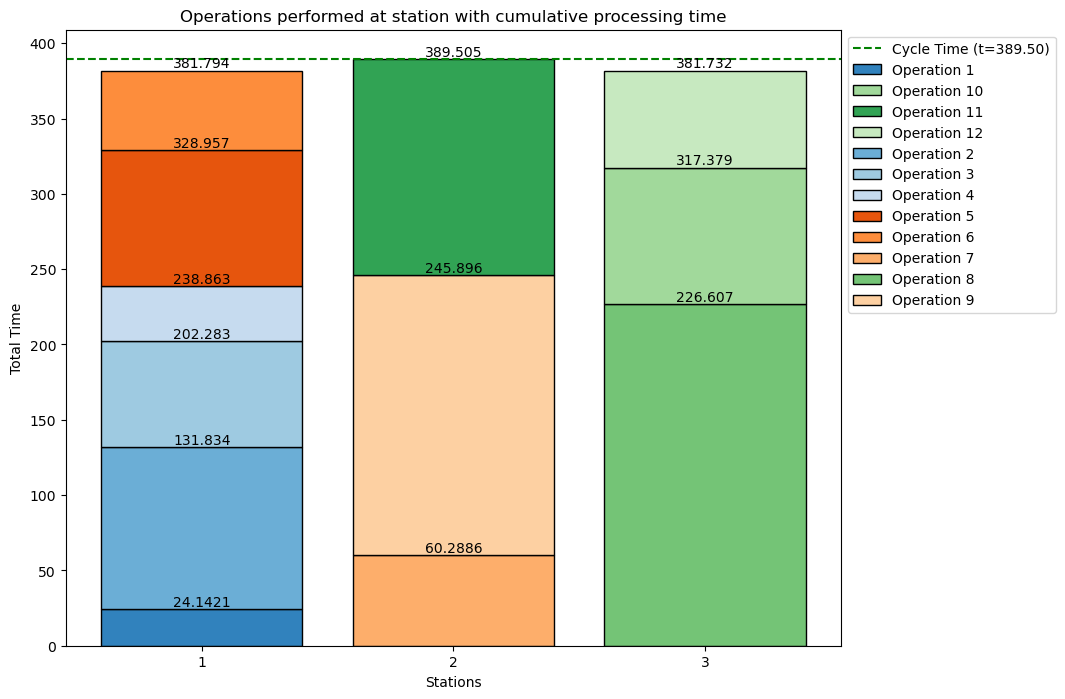

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# Stacked bar chart for visualizing the time at each station, this will nicely show the cycle time
colors = plt.get_cmap("tab20c").colors
color_index = 0

for station in range(0, StationsLength):
    station_sum = 0
    for i in range(0, OperationsLength):
        if converted_op_at_station[i, station]:
            bar = axs.bar(
                station + 1,
                converted_actual_processing_time_per_op[i],
                bottom=station_sum,
                label=f"Operation {i + 1}",
                edgecolor="black",
                color=colors[color_index % len(colors)],
            )
            axs.bar_label(bar)
            station_sum += converted_actual_processing_time_per_op[i]
            color_index += 1


# Draw horizontal line at cycle time
axs.axhline(
    y=data["Cycle_Time"][pstep],
    color="g",
    linestyle="--",
    label=f"Cycle Time (t={data["Cycle_Time"][pstep]:.2f})",
)

# Place legend outside of plot
# Sort the legend labels alphabetically, credit: https://stackoverflow.com/a/27512450/5541326
handles, labels = axs.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axs.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper left")

axs.set_xticks(range(1, StationsLength + 1))
axs.set_xlabel("Stations")
axs.set_ylabel("Total Time")
axs.set_title("Operations performed at station with cumulative processing time")

plt.show()


**Time per station and operation**

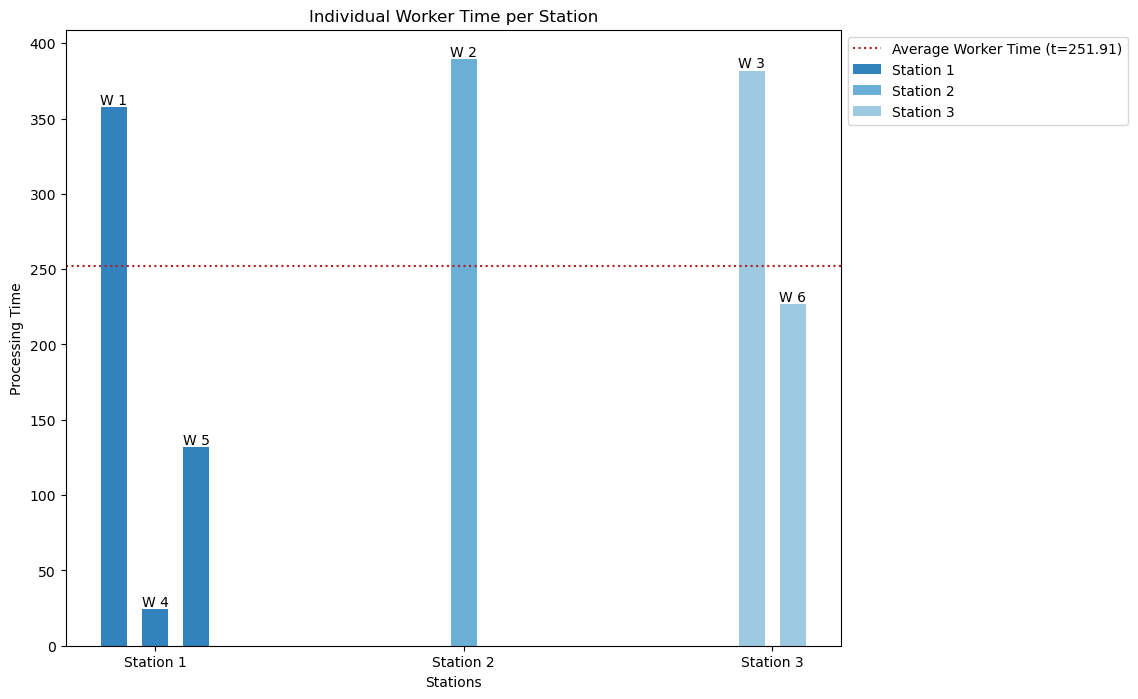

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

bar_width = 0.05
bar_gap = 0.08
group_gap = -0.4

group_multiplier = 0
stations_x_ticks = []
total_sum_workers = []
colors = plt.get_cmap("tab20c").colors
color_index = 0

for station in range(StationsLength):
    workers_sum = []
    worker_labels = []
    bar_positions = []
    for worker in range(WorkerCount):
        worker_station_sum = 0
        if converted_worker_at_station[worker, station]:
            for op in range(OperationsLength):
                worker_station_sum += (
                    converted_worker_at_op[worker, op] * converted_actual_processing_time_per_op[op]
                )
            workers_sum.append(worker_station_sum)
            worker_labels.append(f"W {worker + 1}")
    for i in range(len(workers_sum)):
        bar_positions.append(
            group_multiplier * group_gap
            + station
            + (i - (len(workers_sum) - 1) / 2) * bar_gap
        )
        total_sum_workers.append(workers_sum[i])

    stations_x_ticks.append(group_multiplier * group_gap + station)
    group_multiplier += 1

    bars = axs.bar(
        bar_positions,
        workers_sum,
        bar_width,
        label=f"Station {station + 1}",
        color=colors[color_index % len(colors)],
    )
    color_index += 1
    axs.bar_label(bars, labels=worker_labels, label_type="edge")

# Plot average time per worker as an hline
average_time = np.average(total_sum_workers)
axs.axhline(
    y=average_time,
    color="#af2020",
    linestyle="dotted",
    label=f"Average Worker Time (t={average_time:.2f})",
)

axs.set_xticks(stations_x_ticks)
axs.set_xticklabels([f"Station {i + 1}" for i in range(StationsLength)])

axs.set_title("Individual Worker Time per Station")
axs.set_xlabel("Stations")
axs.set_ylabel("Processing Time")
axs.legend(bbox_to_anchor=(1, 1))

plt.show()


**Worker utilization**

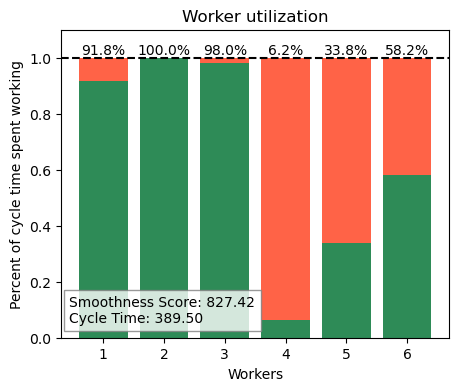

In [51]:
fig, axs = plt.subplots(1, 1, figsize=(5, 4))

worker_times = []

for worker in range(WorkerCount):
    worker_sum = 0
    for i in range(OperationsLength):
        if converted_worker_at_op[worker, i]:
            worker_sum += converted_actual_processing_time_per_op[i]
    worker_times.append(worker_sum)
    bar = axs.bar(worker + 1, worker_sum / cycle_time, color="seagreen")
    notWorkingBar = axs.bar(worker + 1, (cycle_time - worker_sum) / cycle_time, bottom=worker_sum / cycle_time, color="tomato")
    if math.isclose(worker_sum / cycle_time, 1.0, rel_tol=1e-5):
        axs.bar_label(bar, labels=[f"{(worker_sum / cycle_time) * 100:.1f}%"])
    else:
        axs.bar_label(notWorkingBar, labels=[f"{(worker_sum / cycle_time) * 100:.1f}%"])


axs.axhline(
    y=1,
    color="black",
    linestyle="--",
)
axs.set_ybound(0, 1.1)
axs.set_ylabel("Percent of cycle time spent working")
axs.set_xlabel("Workers")
axs.set_title("Worker utilization")

# Add legend with standard deviation information
axs.text(0.02, 0.05, 
         f"Smoothness Score: {smoothness_index:.2f}\n"
         f"Cycle Time: {cycle_time:.2f}", 
         transform=axs.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.show()


**Cycle Time vs Worker Time Standard Deviation**

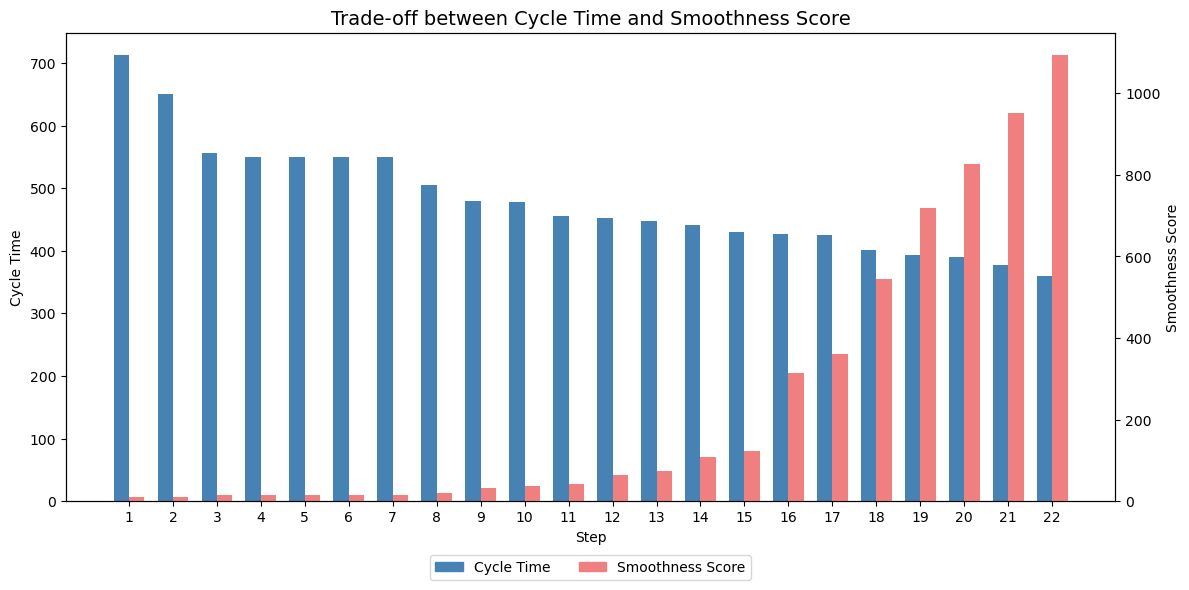

In [52]:
fig, ax1 = plt.subplots(figsize=(12, 6))
# Can toggle labels, should only be used for to accurately read values can be quite cluttered
show_labels = False

width = 0.35
cycle_time_color = 'steelblue'
std_dev_color = 'lightcoral'


cycle_time_values = [i[0] for i in filter_pareto_front(data["pareto_front"])]
smoothness_index_values = [i[1] for i in filter_pareto_front(data["pareto_front"])]
x_values = list(range(len(cycle_time_values)))

# Plot cycle time on left y-axis
bars1 = ax1.bar([x - width/2 for x in x_values], cycle_time_values, width, color=cycle_time_color, 
                label='Cycle Time')
if show_labels:
    ax1.bar_label(bars1)
ax1.set_xlabel('Step')
ax1.set_ylabel('Cycle Time')
ax1.set_xticks(x_values)
ax1.set_xticklabels([f'{step+1}' for step in range(len(cycle_time_values))])
# Create right y-axis for smoothness score
ax2 = ax1.twinx()

# Plot smoothness score on right y-axis
bars2 = ax2.bar([x + width/2 for x in x_values], smoothness_index_values, width, color=std_dev_color, 
                label='Smoothness Score')
if show_labels:
    ax2.bar_label(bars2)
ax2.set_ylabel('Smoothness Score')

plt.title('Trade-off between Cycle Time and Smoothness Score', fontsize=14)

legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=cycle_time_color, label='Cycle Time'),
    plt.Rectangle((0,0), 1, 1, color=std_dev_color, label='Smoothness Score'),
]
ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)


plt.tight_layout()
plt.show()

**Actual worker utilization vs worker utilization when ignoring the modifiers**

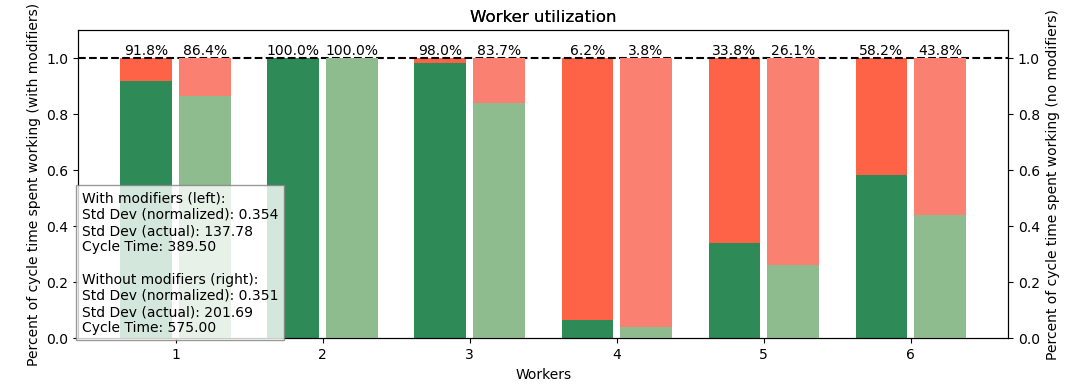

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))

ax2 = ax1.twinx()

converted_theoretical_processing_time_per_op = {eval(k): v for k, v in data["Theoretical_Processing_Time_per_Op"][pstep].items()}

worker_times = []
width = 0.35
offset = 0.2

# Colors with different saturations
actual_seagreen = "seagreen"
actual_tomato = "tomato"
theoretical_seagreen = "darkseagreen"
theoretical_tomato = "salmon"

# Left bars (with modifiers)
for worker in range(WorkerCount):
    worker_sum = 0
    for i in range(OperationsLength):
        if converted_worker_at_op[worker, i]:
            worker_sum += converted_actual_processing_time_per_op[i]
    worker_times.append(worker_sum)
    bar = ax1.bar(worker + 1 - offset, worker_sum / cycle_time, width=width, color=actual_seagreen)
    notWorkingBar = ax1.bar(worker + 1 - offset, (cycle_time - worker_sum) / cycle_time, width=width, 
                          bottom=worker_sum / cycle_time, color=actual_tomato)
    if math.isclose(worker_sum / cycle_time, 1.0, rel_tol=1e-5):
        ax1.bar_label(bar, labels=[f"{(worker_sum / cycle_time) * 100:.1f}%"])
    else:
        ax1.bar_label(notWorkingBar, labels=[f"{(worker_sum / cycle_time) * 100:.1f}%"])

            
# Calculate standard deviations
worker_times_array = np.array(worker_times)
std_dev_actual = np.std(worker_times_array)
std_dev_normalized = np.std(worker_times_array / cycle_time)

ax1.axhline(
    y=1,
    color="black",
    linestyle="--",
)
ax1.set_ybound(0, 1.1)
ax1.set_ylabel("Percent of cycle time spent working (with modifiers)")
ax1.set_xlabel("Workers")
ax1.set_title("Worker utilization")

# Calculate cycle time without modifiers
cycle_time_no_modifiers = 0
for station in range(StationsLength):
    station_sum = 0
    for i in range(OperationsLength):
        if converted_op_at_station[i, station]:
            station_sum += converted_theoretical_processing_time_per_op[i]
    cycle_time_no_modifiers = max(cycle_time_no_modifiers, station_sum)

# Right bars (no modifiers)
worker_times_no_modifiers = []
for worker in range(WorkerCount):
    worker_sum = 0
    for i in range(OperationsLength):
        if converted_worker_at_op[worker, i]:
            worker_sum += converted_theoretical_processing_time_per_op[i]
    worker_times_no_modifiers.append(worker_sum)
    bar = ax2.bar(worker + 1 + offset, worker_sum / cycle_time_no_modifiers, width=width, color=theoretical_seagreen)
    notWorkingBar = ax2.bar(worker + 1 + offset, (cycle_time_no_modifiers - worker_sum) / cycle_time_no_modifiers, width=width, 
                           bottom=worker_sum / cycle_time_no_modifiers, color=theoretical_tomato)
    if math.isclose(worker_sum / cycle_time, 1.0, rel_tol=1e-5):
        ax2.bar_label(bar, labels=[f"{(worker_sum / cycle_time_no_modifiers) * 100:.1f}%"])
    else:
        ax2.bar_label(notWorkingBar, labels=[f"{(worker_sum / cycle_time_no_modifiers) * 100:.1f}%"])

            
# Calculate standard deviations
worker_times_no_modifiers_array = np.array(worker_times_no_modifiers)
std_dev_no_modifiers_actual = np.std(worker_times_no_modifiers_array)
std_dev_no_modifiers_normalized = np.std(worker_times_no_modifiers_array / cycle_time_no_modifiers)

ax2.set_ybound(0, 1.1)
ax2.set_ylabel("Percent of cycle time spent working (no modifiers)")
ax2.set_xlabel("Workers")
ax2.set_title("Worker utilization")

# Add legend with standard deviation information
ax2.text(0.05, 0.05, 
         f"With modifiers (left):\n"
         f"Std Dev (normalized): {std_dev_normalized:.3f}\n"
         f"Std Dev (actual): {std_dev_actual:.2f}\n"
         f"Cycle Time: {cycle_time:.2f}\n"
         f"\nWithout modifiers (right):\n"
         f"Std Dev (normalized): {std_dev_no_modifiers_normalized:.3f}\n"
         f"Std Dev (actual): {std_dev_no_modifiers_actual:.2f}\n"
         f"Cycle Time: {cycle_time_no_modifiers:.2f}", 
         transform=axs.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.show()

**Time per station with assigned workers**

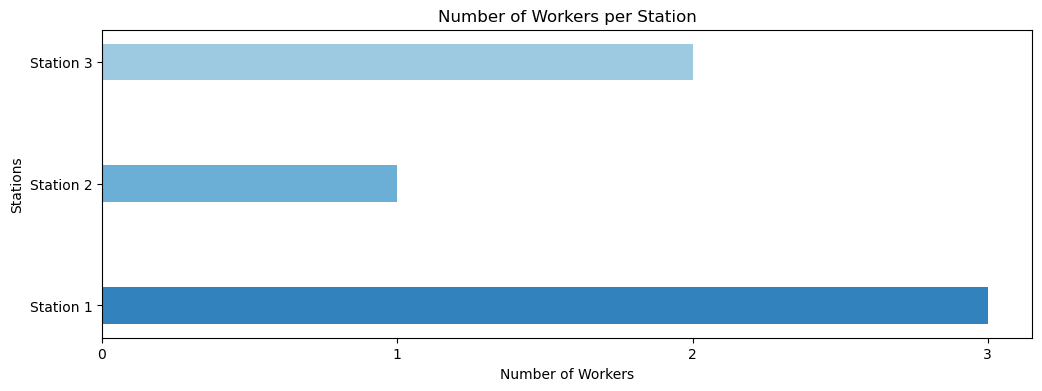

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))

# Horizontal bar chart for visualizing the number of workers at each station
colors = plt.get_cmap("tab20c").colors
color_index = 0
max_workers = 0

for station in range(0, StationsLength):
    workers = 0
    for i in range(0, WorkerCount):
        if converted_worker_at_station[i, station]:
            workers += 1
    bar = axs.barh(
        station + 1,
        workers,
        height=0.3,
        label=f"Station {station + 1}",
        color=colors[color_index % len(colors)],
    )
    if max_workers < workers:
        max_workers = workers
    color_index += 1

axs.set_yticks(range(1, StationsLength + 1))
axs.set_yticklabels([f"Station {i + 1}" for i in range(StationsLength)])
axs.set_ylabel("Stations")
axs.set_xlabel("Number of Workers")
axs.set_xticks(range(0, max_workers + 1))
axs.set_title("Number of Workers per Station")

plt.show()


**Number of tasks per worker**

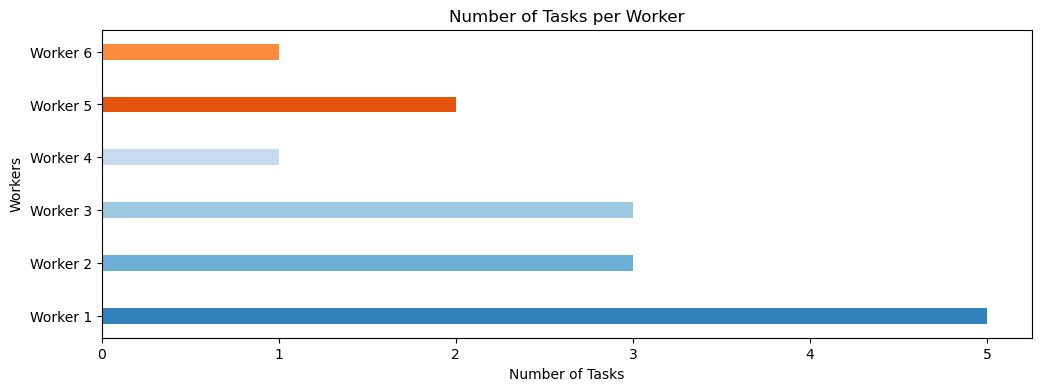

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))

# Horizontal bar chart for visualizing the number of tasks for each worker
colors = plt.get_cmap("tab20c").colors
color_index = 0

max_tasks = 0

for worker in range(0, WorkerCount):
    tasks = 0
    for i in range(0, OperationsLength):
        if converted_worker_at_op[worker, i]:
            tasks += 1
    bar = axs.barh(
        worker + 1,
        tasks,
        height=0.3,
        label=f"Worker {worker + 1}",
        color=colors[color_index % len(colors)],
    )
    if max_tasks < tasks:
        max_tasks = tasks
    color_index += 1

axs.set_yticks(range(1, WorkerCount + 1))
axs.set_yticklabels([f"Worker {i + 1}" for i in range(WorkerCount)])
axs.set_ylabel("Workers")
axs.set_xlabel("Number of Tasks")
axs.set_xticks(range(0, max_tasks + 1))
axs.set_title("Number of Tasks per Worker")


plt.show()